## Multi-Label Classification of Responses to the AUT

In the study, we want to classify responses to a creativity task (in this case the AUT) to labels which are based on semantic similarity. Meaning that responses which are semanticaly similar, such as *building a house* and *building a tower* are classified to the same label: *building*. Moreover, responses should be classified to not just one class, but possibly more classes. Which makes this a multi-label classification problem. To realise this assignment we are going to use sentence encodings for the responses to the AUT task. Based on these sentence encodings, we will train an algorithm which can use these sentence ecodings as input features. But what types of machine learning algorithms are fitted for a multi-label classification problem?

- Neural Network
- Multi-label adapted KNN classifier
- Sci-kit learn provides inbuilt support of multi-label classification in some of the algorithm like Random Forest and Ridge regression. So, you can directly call them and predict the output.

You can check the multi-learn library if you wish to learn more about other types of adapted algorithm.

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import tensorflow_text


# import data file
data = pd.read_csv("data.csv", encoding = 'latin-1')
data.head()

,research_id,response_id,respondent_id,object,original_response,cleaned_response,C0,C1,C2,C3,...,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63
0,CES201610,10063.0,648,brick,aambeeld,aambeeld,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CES201610,5801.0,363,brick,het aanleggen van een weg,aanleggen weg,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,CES201610,3973.0,237,brick,aannemen,aannemen,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CES201610,5226.0,300,brick,aannemer,aannemer,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,CES201610,8321.0,555,brick,aarde,aarde,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### **Universal Sentence Encoder**

Now we have our dataset in which we have textual responses to the AUT test. From these responses, we need the sentence encodings. Therefore we load the USE module from google. You can find this module here: https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3

In [3]:
# Numpy array containing all original responses
responses  = data[['original_response']].to_numpy()

# Load the module
module     = hub.load('https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3')

# Fit the module on the reponses
embeddings = module(responses)

# Insert the embeddings to the dataframe
data.insert(6, "embeddings", embeddings)
data.head()

,research_id,response_id,respondent_id,object,original_response,cleaned_response,embeddings,C0,C1,C2,...,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63
0,CES201610,10063.0,648,brick,aambeeld,aambeeld,"(tf.Tensor(-0.0033594382, shape=(), dtype=floa...",0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CES201610,5801.0,363,brick,het aanleggen van een weg,aanleggen weg,"(tf.Tensor(-0.04237993, shape=(), dtype=float3...",0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,CES201610,3973.0,237,brick,aannemen,aannemen,"(tf.Tensor(-0.0497488, shape=(), dtype=float32...",0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CES201610,5226.0,300,brick,aannemer,aannemer,"(tf.Tensor(-0.035619657, shape=(), dtype=float...",0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,CES201610,8321.0,555,brick,aarde,aarde,"(tf.Tensor(-0.0018414989, shape=(), dtype=floa...",1,0,0,...,0,0,0,0,0,0,0,0,0,0


Lets take a look at the correlations between the labels:

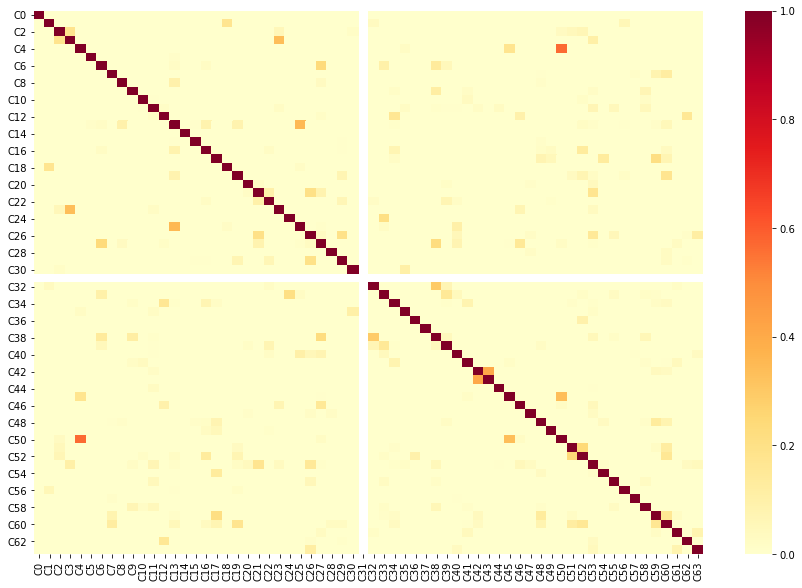

In [5]:
# import seaborn and matplot
import seaborn as sns
import matplotlib.pyplot as plt

# Selecteer enkel de continue variabelen
numeric_cols = data.loc[:, 'C0':'C63']

# correlatie heatmap
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(numeric_cols.corr(), cmap='YlOrRd', fmt='.2f', vmin=0)

### Multi-Label Classification

We will now go through a number of different classifiers, available in the scikit multilearn package: http://scikit.ml/modelselection.html

The following classifiers will be used on the data:
- Binary Relevance kNN
- Multi-label kNN
- Multi-label ARAM
- Binary Relevance: Random Forest Classifier
- Classifier Chain: Random Forest Classifier
- Neural Network

As you can see, a column has been added which contains the sentence encodings based on the USE. With these sentence encodings, we can now continue to train variety of models. The data is split into a training (90%) and a test (10%) set. 

In [6]:
from sklearn.model_selection import train_test_split

# Dependent variables
Y        = data.iloc[:, 7:71].to_numpy()

# Independent variables
X        = embeddings.numpy()

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state = 0)

We also have functions for two of our own metrics:

- For the first measure of prediction accuracy, the algorithms predictions and the true test set are multiplied. Resulting in a matrix containing 1’s when both matrixes contain 1’s at the same categories and 0’s when they are not in agreement or both 0. By taking the row sums of this new matrix and dividing by the row sums of the experts’ matrix we get a measure of agreement per row. By taking the mean of this row sum division, we get a matrix of agreement, which was interpreted as our first measure of prediction accuracy. 

- For the second measure of prediction accuracy, the algorithms predictions and the true test set are compared to where they are equal to each other. By taking the mean of this proportion equal versus not equal, we get our second measure of agreement between the two matrices. 

In [81]:
import statistics
sm = int()
mn = int()

def row_sum(predictions, test):
    sm = statistics.mean((predictions * test).sum(axis = 1) / test.sum(axis = 1))
    return sm
    
def row_mean(predictions, test):
    mn = statistics.mean((predictions == test).mean(axis = 1))
    return mn

### Binary Relevance kNN

Binary Relevance multi-label classifier based on k-Nearest Neighbors method. This version of the classifier assigns the labels that are assigned to at least half of the neighbors.

**Strong sides:** - takes some label relations into account while estimating single-label classifers - works when distance between samples is a good predictor for label assignment. Often used in biosciences.

**Weak sides:** - trains a classifier per label - less suitable for large label space - requires parameter estimation.

In [7]:
from skmultilearn.adapt import BRkNNaClassifier
from sklearn.model_selection import GridSearchCV

parameters = {'k': range(1,5)}
score      = 'f1_micro'

clf        = GridSearchCV(BRkNNaClassifier(), parameters, scoring = score)
clf.fit(X_train, y_train)

print('best parameters:', clf.best_params_,
      'best score: ',clf.best_score_)

best parameters: {'k': 3} best score:  0.6738035553404391


In [10]:
from skmultilearn.adapt import BRkNNaClassifier
import sklearn.metrics as metrics

clf         = BRkNNaClassifier(k = 3)

# train
clf.fit(X_train, y_train)

# predict
predictions = clf.predict(X_test)

# hamming loss
ham         = metrics.hamming_loss(y_test, predictions)
precision   = metrics.precision_score(y_test, predictions, average = 'micro')
recall      = metrics.recall_score(y_test, predictions, average = 'micro')
f1          = metrics.f1_score(y_test, predictions, average = 'micro')

print("Binary Relevance kNN: Hamming loss:", round(ham, 3))
print("Binary Relevance kNN: Precision:", round(precision, 3))
print("Binary Relevance kNN: Recall:", round(recall, 3))
print("Binary Relevance kNN: F-1:", round(f1, 3))

Binary Relevance kNN: Hamming loss: 0.012
Binary Relevance kNN: Precision: 0.761
Binary Relevance kNN: Recall: 0.639
Binary Relevance kNN: F-1: 0.695


### Multi-label kNN

kNN classification method adapted for multi-label classification. MLkNN uses k-NearestNeighbors to find nearest examples to a test class and uses Bayesian inference to select assigned labels.

**Strong sides:** - estimates one multi-class subclassifier - works when distance between samples is a good predictor for label assignment - often used in biosciences.

**Weak sides:** - requires parameter estimation

In [11]:
from skmultilearn.adapt import MLkNN

parameters = {'k': range(1,3), 's': [0.5, 0.7, 1.0]}
score      = 'f1_micro'

clf        = GridSearchCV(MLkNN(), parameters, scoring = score)
clf.fit(X_train, y_train)

print('best parameters:', clf.best_params_, 'best score: ',
      clf.best_score_)

best parameters: {'k': 1, 's': 0.5} best score:  0.6720327983742633


In [14]:
clf         = MLkNN(k = 1, s = 0.5)

# train
clf.fit(X_train, y_train)

# predict
predictions = clf.predict(X_test)

# hamming loss
ham2         = metrics.hamming_loss(y_test, predictions)
precision2   = metrics.precision_score(y_test, predictions, average = 'micro')
recall2      = metrics.recall_score(y_test, predictions, average = 'micro')
f12          = metrics.f1_score(y_test, predictions, average = 'micro')

print("Multilabel kNN: Hamming loss:", round(ham2, 3))
print("Multilabel kNN: Precision:", round(precision2, 3))
print("Multilabel kNN: Recall:", round(recall2, 3))
print("Multilabel kNN: F-1:", round(f12, 3))

Multilabel kNN: Hamming loss: 0.014
Multilabel kNN: Precision: 0.683
Multilabel kNN: Recall: 0.659
Multilabel kNN: F-1: 0.671


### Multi-label ARAM

A Hierarchical ARAM Neural Network for Large-Scale Text Classification. This method aims at increasing the classification speed by adding an extra ART layer for clustering learned prototypes into large clusters. In this case the activation of all prototypes can be replaced by the activation of a small fraction of them, leading to a significant reduction of the classification time.

**Strong sides:** - linear in number of samples, scales well

**Weak sides:** - requires parameter estimation - ART techniques have had generalization limits in the past

In [15]:
from skmultilearn.adapt import MLARAM

clf         = MLARAM(threshold = 0.05, vigilance = 0.95)

# train
clf.fit(X_train, y_train)

# predict
predictions = clf.predict(X_test)

# hamming loss
ham3         = metrics.hamming_loss(y_test, predictions)
precision3   = metrics.precision_score(y_test, predictions, average = 'micro')
recall3      = metrics.recall_score(y_test, predictions, average = 'micro')
f13          = metrics.f1_score(y_test, predictions, average = 'micro')

print("Multi-label ARAM: Hamming loss", round(ham3, 3))
print("Multi-label ARAM: Precision:", round(precision3, 3))
print("Multi-label ARAM: Recall:", round(recall3, 3))
print("Multi-label ARAM: F-1:", round(f13, 3))

Multi-label ARAM: Hamming loss 0.014
Multi-label ARAM: Precision: 0.669
Multi-label ARAM: Recall: 0.698
Multi-label ARAM: F-1: 0.683


### Binary Relevance: Random Forest Classifier

Performs classification per label

Transforms a multi-label classification problem with L labels into L single-label separate binary classification problems using the same base classifier provided in the constructor. The prediction output is the union of all per label classifiers.

**Strong sides:** - estimates single-label classifiers - can generalize beyond avialable label combinations

**Weak sides:** - not suitable for large number of labels - ignores label relations

In [18]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.ensemble import RandomForestClassifier

classifier = BinaryRelevance(
    classifier = RandomForestClassifier(),
    require_dense = [False, True]
)

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)

# test
ham4         = metrics.hamming_loss(y_test, predictions)
precision4   = metrics.precision_score(y_test, predictions, average = 'micro')
recall4      = metrics.recall_score(y_test, predictions, average = 'micro')
f14          = metrics.f1_score(y_test, predictions, average = 'micro')

print("Binary Relevance, Random Forest: Hamming loss", round(ham4, 3))
print("Binary Relevance, Random Forest: Precision:", round(precision4, 3))
print("Binary Relevance, Random Forest: Recall:", round(recall4, 3))
print("Binary Relevance, Random Forest: F-1:", round(f14, 3))

Binary Relevance, Random Forest: Hamming loss 0.011
Binary Relevance, Random Forest: Precision: 0.879
Binary Relevance, Random Forest: Recall: 0.548
Binary Relevance, Random Forest: F-1: 0.675


### Classifier Chain: Random Forest Classifier

Transforms multi-label problem to a multi-class problem where each label combination is a separate class. The first classifier is trained just on the input space, and then each next classifier is trained on the input space and all previous classifiers in the chain.

**Strong sides:** - estimates single-label classifiers - can generalize beyond avialable label combinations - takes label relations into account

**Weak sides:** - not suitable for large number of labels - quality strongly depends on the label ordering in chain.

First, we will order the labels by highest occurence:

In [42]:
from sklearn.model_selection import train_test_split

# Dependent variables
Y        = data.iloc[:, 7:71]
order    = Y.sum().sort_values(ascending = False)

order    = [1, 0, 2, 26, 23, 53, 5, 28, 50, 11, 29, 38, 6, 4, 3, 13, 17, 21, 20, 51, 7, 32, 60, 48, 18, 59,
           52, 27, 57, 58, 40, 39, 45, 8, 22, 56, 49, 25, 47, 34, 55, 9, 19, 41, 14, 33, 12, 36, 15, 10, 35,
           16, 43, 62, 61, 44, 63, 37, 54, 42, 30, 46, 24, 31] # setting column's order
Y        = Y[[Y.columns[i] for i in order]]

# Independent variables
X        = embeddings.numpy()

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state = 0)

In [44]:
from skmultilearn.problem_transform import ClassifierChain

classifier = ClassifierChain(
    classifier = RandomForestClassifier(),
    require_dense = [False, True]
)

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)

# test
ham5         = metrics.hamming_loss(y_test, predictions)
precision5   = metrics.precision_score(y_test, predictions, average = 'micro')
recall5      = metrics.recall_score(y_test, predictions, average = 'micro')
f15          = metrics.f1_score(y_test, predictions, average = 'micro')

print("Classifier Chain, Random Forest: Hamming loss", round(ham5, 3))
print("Classifier Chain, Random Forest: Precision:", round(precision5, 3))
print("Classifier Chain, Random Forest: Recall:", round(recall5, 3))
print("Classifier Chain, Random Forest: F-1:", round(f15, 3))

Classifier Chain, Random Forest: Hamming loss 0.011
Classifier Chain, Random Forest: Precision: 0.869
Classifier Chain, Random Forest: Recall: 0.55
Classifier Chain, Random Forest: F-1: 0.674


### Neural Network

To select the optimal neural network, we use hyperparameter tuning with the keras package. The following hyperparameters will be tuned:

- Number of hidden layers (2 - 6)
- Number of nodes within the hidden layers (32 - 800 with steps of 32)
- Learning rate (0.01, 0.001, 0.0001)


We have 2 till 6 sequential layers which are fully connected. Fully connected layers are defined using the Dense class. We use a sigmoid on the output layer to ensure our network output is between 0 and 1.

**Epoch:** One pass through all of the rows in the training dataset (100).

**Batch:** One or more samples considered by the model within an epoch before weights are updated (32).

In [9]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hypermodel import HyperModel
from kerastuner.engine.hyperparameters import HyperParameters


# Dependent variables
Y        = data.iloc[:, 7:71].to_numpy()

# Independent variables
X        = embeddings.numpy()

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state = 0)

# Define the model
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten(input_shape = (512, )))
    # Tune the number of units looping over 2 till 6 Dense layers
    # Choose an optimal value for every layer between 32-800
    for i in range(hp.Int('num_layers', 2, 4)):
        model.add(layers.Dense(units = hp.Int('units_' + str(i),
                                            min_value = 32,
                                            max_value = 800,
                                            step = 32),
                               activation = 'relu'))
    # Add final output layer with sigmoid activation
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation = 'sigmoid'))
    
    # Tune the learning rate for the optimizer 
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    model.compile(
        optimizer = keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss = 'binary_crossentropy',
        metrics = ['categorical_accuracy'])
    return model

# Initiate the tuner
tuner = RandomSearch(
    build_model,
    objective = 'val_categorical_accuracy',
    max_trials = 5,
    executions_per_trial = 3,
    directory = '/MLC',
    project_name = 'multi-label-classification')

tuner.search_space_summary()

#### Now it is time to search for the best hyperparameters!

In [10]:
# Search for best model
tuner.search(X_train, y_train, validation_data = (X_test, y_test), epochs = 100, batch_size = 32)

Train on 5400 samples, validate on 600 samples
Epoch 1/100
5400/5400 [==============================] - ETA: 42s - loss: 0.6936 - categorical_accuracy: 0.0000e+0 - ETA: 0s - loss: 0.4004 - categorical_accuracy: 0.0174    - ETA: 0s - loss: 0.2518 - categorical_accuracy: 0.13 - ETA: 0s - loss: 0.1959 - categorical_accuracy: 0.17 - 1s 98us/sample - loss: 0.1692 - categorical_accuracy: 0.2124 - val_loss: 0.0776 - val_categorical_accuracy: 0.3400
Epoch 2/100
5400/5400 [==============================] - ETA: 0s - loss: 0.1073 - categorical_accuracy: 0.31 - ETA: 0s - loss: 0.0745 - categorical_accuracy: 0.34 - ETA: 0s - loss: 0.0733 - categorical_accuracy: 0.35 - ETA: 0s - loss: 0.0723 - categorical_accuracy: 0.37 - 0s 43us/sample - loss: 0.0716 - categorical_accuracy: 0.3900 - val_loss: 0.0669 - val_categorical_accuracy: 0.4583
Epoch 3/100
5400/5400 [==============================] - ETA: 1s - loss: 0.0633 - categorical_accuracy: 0.53 - ETA: 0s - loss: 0.0621 - categorical_accuracy: 0.48 - E

Train on 5400 samples, validate on 600 samples
Epoch 1/100
5400/5400 [==============================] - ETA: 38s - loss: 0.6926 - categorical_accuracy: 0.093 - ETA: 0s - loss: 0.6659 - categorical_accuracy: 0.236 - ETA: 0s - loss: 0.5259 - categorical_accuracy: 0.13 - ETA: 0s - loss: 0.3852 - categorical_accuracy: 0.16 - 0s 88us/sample - loss: 0.3456 - categorical_accuracy: 0.1733 - val_loss: 0.0919 - val_categorical_accuracy: 0.3033
Epoch 2/100
5400/5400 [==============================] - ETA: 0s - loss: 0.0994 - categorical_accuracy: 0.21 - ETA: 0s - loss: 0.0879 - categorical_accuracy: 0.27 - ETA: 0s - loss: 0.0875 - categorical_accuracy: 0.26 - ETA: 0s - loss: 0.0873 - categorical_accuracy: 0.26 - 0s 36us/sample - loss: 0.0866 - categorical_accuracy: 0.2665 - val_loss: 0.0858 - val_categorical_accuracy: 0.3033
Epoch 3/100
5400/5400 [==============================] - ETA: 0s - loss: 0.0886 - categorical_accuracy: 0.31 - ETA: 0s - loss: 0.0851 - categorical_accuracy: 0.25 - ETA: 0s -

Train on 5400 samples, validate on 600 samples
Epoch 1/100
5400/5400 [==============================] - ETA: 39s - loss: 0.6919 - categorical_accuracy: 0.0000e+0 - ETA: 2s - loss: 0.6716 - categorical_accuracy: 0.0197    - ETA: 1s - loss: 0.6184 - categorical_accuracy: 0.05 - ETA: 0s - loss: 0.5066 - categorical_accuracy: 0.07 - ETA: 0s - loss: 0.4078 - categorical_accuracy: 0.11 - ETA: 0s - loss: 0.3448 - categorical_accuracy: 0.14 - ETA: 0s - loss: 0.3025 - categorical_accuracy: 0.16 - ETA: 0s - loss: 0.2717 - categorical_accuracy: 0.17 - ETA: 0s - loss: 0.2487 - categorical_accuracy: 0.18 - ETA: 0s - loss: 0.2302 - categorical_accuracy: 0.20 - 1s 147us/sample - loss: 0.2252 - categorical_accuracy: 0.2044 - val_loss: 0.0845 - val_categorical_accuracy: 0.3033
Epoch 2/100
5400/5400 [==============================] - ETA: 0s - loss: 0.0672 - categorical_accuracy: 0.31 - ETA: 0s - loss: 0.0824 - categorical_accuracy: 0.25 - ETA: 0s - loss: 0.0820 - categorical_accuracy: 0.26 - ETA: 0s - 

Train on 5400 samples, validate on 600 samples
Epoch 1/100
5400/5400 [==============================] - ETA: 38s - loss: 0.6917 - categorical_accuracy: 0.0000e+0 - ETA: 1s - loss: 0.1340 - categorical_accuracy: 0.1918    - ETA: 0s - loss: 0.1051 - categorical_accuracy: 0.25 - ETA: 0s - loss: 0.0942 - categorical_accuracy: 0.30 - ETA: 0s - loss: 0.0860 - categorical_accuracy: 0.34 - 1s 102us/sample - loss: 0.0811 - categorical_accuracy: 0.3663 - val_loss: 0.0577 - val_categorical_accuracy: 0.5483
Epoch 2/100
5400/5400 [==============================] - ETA: 0s - loss: 0.0454 - categorical_accuracy: 0.65 - ETA: 0s - loss: 0.0510 - categorical_accuracy: 0.57 - ETA: 0s - loss: 0.0501 - categorical_accuracy: 0.58 - ETA: 0s - loss: 0.0487 - categorical_accuracy: 0.58 - ETA: 0s - loss: 0.0484 - categorical_accuracy: 0.58 - 0s 50us/sample - loss: 0.0476 - categorical_accuracy: 0.5874 - val_loss: 0.0458 - val_categorical_accuracy: 0.6233
Epoch 3/100
5400/5400 [==============================] - 

Train on 5400 samples, validate on 600 samples
Epoch 1/100
5400/5400 [==============================] - ETA: 42s - loss: 0.6940 - categorical_accuracy: 0.031 - ETA: 0s - loss: 0.2529 - categorical_accuracy: 0.173 - ETA: 0s - loss: 0.1696 - categorical_accuracy: 0.22 - ETA: 0s - loss: 0.1402 - categorical_accuracy: 0.24 - 1s 96us/sample - loss: 0.1275 - categorical_accuracy: 0.2537 - val_loss: 0.0757 - val_categorical_accuracy: 0.3483
Epoch 2/100
5400/5400 [==============================] - ETA: 0s - loss: 0.0662 - categorical_accuracy: 0.37 - ETA: 0s - loss: 0.0729 - categorical_accuracy: 0.34 - ETA: 0s - loss: 0.0714 - categorical_accuracy: 0.37 - ETA: 0s - loss: 0.0699 - categorical_accuracy: 0.39 - 0s 40us/sample - loss: 0.0688 - categorical_accuracy: 0.3996 - val_loss: 0.0628 - val_categorical_accuracy: 0.5067
Epoch 3/100
5400/5400 [==============================] - ETA: 0s - loss: 0.0577 - categorical_accuracy: 0.50 - ETA: 0s - loss: 0.0560 - categorical_accuracy: 0.50 - ETA: 0s -

INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [13]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of layers is {best_hps.get('num_layers')}. The optimal number
of units in the first densely-connected layer is {best_hps.get('units_1')}. The optimal number
of units in the second densely-connected layer is {best_hps.get('units_2')}. The optimal number
of units in the third densely-connected layer is {best_hps.get('units_3')} Final, the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")
print(tuner.results_summary(num_trials = 1))


The hyperparameter search is complete. The optimal number of layers is 3. The optimal number
of units in the first densely-connected layer is 544. The optimal number
of units in the second densely-connected layer is 736. The optimal number
of units in the third densely-connected layer is 32 Final, the optimal learning rate for the optimizer
is 0.0001.



None


In [14]:
# Build the model with the optimal hyperparameters and train it on the data
model   = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), 
                    epochs = 100, batch_size = 64)

Train on 5400 samples, validate on 600 samples
Epoch 1/100
5400/5400 [==============================] - ETA: 19s - loss: 0.6937 - categorical_accuracy: 0.0000e+0 - ETA: 1s - loss: 0.6784 - categorical_accuracy: 0.0193    - ETA: 0s - loss: 0.6430 - categorical_accuracy: 0.02 - ETA: 0s - loss: 0.5569 - categorical_accuracy: 0.01 - ETA: 0s - loss: 0.4593 - categorical_accuracy: 0.03 - ETA: 0s - loss: 0.3872 - categorical_accuracy: 0.08 - 1s 105us/sample - loss: 0.3718 - categorical_accuracy: 0.0902 - val_loss: 0.0922 - val_categorical_accuracy: 0.3033
Epoch 2/100
5400/5400 [==============================] - ETA: 0s - loss: 0.0889 - categorical_accuracy: 0.21 - ETA: 0s - loss: 0.0906 - categorical_accuracy: 0.25 - ETA: 0s - loss: 0.0882 - categorical_accuracy: 0.26 - ETA: 0s - loss: 0.0871 - categorical_accuracy: 0.26 - ETA: 0s - loss: 0.0863 - categorical_accuracy: 0.26 - ETA: 0s - loss: 0.0854 - categorical_accuracy: 0.26 - 0s 52us/sample - loss: 0.0854 - categorical_accuracy: 0.2665 - v

#### *It takes around a minute to train in 100 epochs. In the last epoch, our categorical accuracy on the training data is 85% and test data is 68%. However, we still need to select the best corresponding threshold:*

In [82]:
# now we can test the accuracy of the model on the test data
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss

# make model predictions
y_pred         = model.predict(X_test)
thresholds     = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

for val in thresholds:
    predictions       = y_pred.copy()
  
    predictions[predictions >= val] = 1
    predictions[predictions < val]  = 0

    precision   = precision_score(y_test, predictions, average = 'micro')
    recall      = recall_score(y_test, predictions, average = 'micro')
    f1          = f1_score(y_test, predictions, average = 'micro')
    hamming     = hamming_loss(y_test, predictions)
    sum_metric  = row_sum(predictions, y_test)
    mean_metric = row_mean(predictions, y_test)
   
    print("Micro-average quality numbers")
    print("Threshold: {:.1f}".format(val))
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}, Hamming loss: {:.4f}, Sum Metric: {:.4f}, Mean Metric: {:.4f}".format(precision, 
                                                                                               recall, f1, hamming, sum_metric, mean_metric))

Micro-average quality numbers
Threshold: 0.1
Precision: 0.5885, Recall: 0.7936, F1-measure: 0.6758, Hamming loss: 0.0160, Sum Metric: 0.8139, Mean Metric: 0.9840
Micro-average quality numbers
Threshold: 0.2
Precision: 0.6538, Recall: 0.7565, F1-measure: 0.7014, Hamming loss: 0.0136, Sum Metric: 0.7850, Mean Metric: 0.9864
Micro-average quality numbers
Threshold: 0.3
Precision: 0.6992, Recall: 0.7355, F1-measure: 0.7169, Hamming loss: 0.0122, Sum Metric: 0.7683, Mean Metric: 0.9878
Micro-average quality numbers
Threshold: 0.4
Precision: 0.7345, Recall: 0.7046, F1-measure: 0.7192, Hamming loss: 0.0116, Sum Metric: 0.7404, Mean Metric: 0.9884
Micro-average quality numbers
Threshold: 0.5
Precision: 0.7699, Recall: 0.6700, F1-measure: 0.7165, Hamming loss: 0.0112, Sum Metric: 0.7115, Mean Metric: 0.9888
Micro-average quality numbers
Threshold: 0.6
Precision: 0.8094, Recall: 0.6403, F1-measure: 0.7150, Hamming loss: 0.0108, Sum Metric: 0.6840, Mean Metric: 0.9892
Micro-average quality number

Based on the evaluation of the thresholds, we reached an accuracy score of 81% using a threshold of .7. 

- The hamming loss (HL) is: the fraction of the wrong labels to the total number of labels
- Precision (also called positive predictive value) is the fraction of relevant instances among the retrieved instances
- While recall (also known as sensitivity) is the fraction of the total amount of relevant instances that were actually retrieved.
- F-1 score is the harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall).

Lets look at a visualization of the training and validation epochs to see how the model is working:

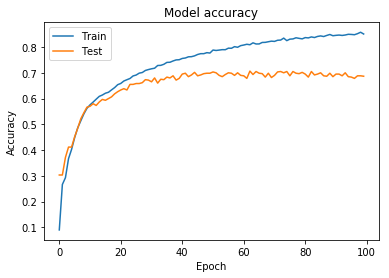

In [16]:
import matplotlib.pyplot as plt
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

We create a set that contains the predictions by the model for the test data, and a set that contains the results by the raters:

In [53]:
# Dependent variables
Y        = data.iloc[:, 7:71]

# Independent variables
X        = embeddings.numpy()

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state = 0)

# corresponding responses to test set
corr_response = data.iloc[y_test.index, 5].reset_index(drop = True)
co_response   = data.iloc[y_test.index, 5]

# create a dataframe for the predictions by the neural network
df = pd.DataFrame(data = y_pred[0:,0:],
                  index = [i for i in range(y_pred.shape[0])],
                  columns = ['C' + str(i) for i in range(y_pred.shape[1])])

pred_data = pd.concat([corr_response, df], axis = 1)
true_data = pd.concat([co_response, y_test], axis = 1).reset_index(drop = True)

# Write to csv files
pred_data.to_csv('algorithm_predictions.csv')
true_data.to_csv('true_data.csv')

Now we can compare the raters with each other and the raters to the algorithms predictions. To do so, we compute the average Hamming loss. The Hamming loss is the fraction of labels that are incorrectly predicted. Ideally, we would expect the hamming loss to be HL = 0, this would imply no error.

#### Lets start with rater vs rater:

In [65]:
from sklearn.metrics import hamming_loss

# Load all raters
rater01      = pd.read_csv("data_rater1.csv", encoding = 'latin-1')
rater02      = pd.read_csv("data_rater2.csv", encoding = 'latin-1')
rater03      = pd.read_csv("data_rater3.csv", encoding = 'latin-1')

# Rater 1 vs Rater 2
rater01_02   = hamming_loss(rater01.iloc[:, 6:71], rater02.iloc[:, 6:71])
precision1   = precision_score(rater01.iloc[:, 6:71], rater02.iloc[:, 6:71], average = 'micro')
recall1      = recall_score(rater01.iloc[:, 6:71], rater02.iloc[:, 6:71], average = 'micro')
f11          = f1_score(rater01.iloc[:, 6:71], rater02.iloc[:, 6:71], average = 'micro')
sum_metric1  = row_sum(rater01.iloc[:, 6:71], rater02.iloc[:, 6:71])
mean_metric1 = row_mean(rater01.iloc[:, 6:71], rater02.iloc[:, 6:71])

# Rater 1 vs Rater 3
rater01_03   = hamming_loss(rater01.iloc[:, 6:71], rater03.iloc[:, 6:71])
precision2   = precision_score(rater01.iloc[:, 6:71], rater03.iloc[:, 6:71], average = 'micro')
recall2      = recall_score(rater01.iloc[:, 6:71], rater03.iloc[:, 6:71], average = 'micro')
f12          = f1_score(rater01.iloc[:, 6:71], rater03.iloc[:, 6:71], average = 'micro')
sum_metric2  = row_sum(rater01.iloc[:, 6:71], rater03.iloc[:, 6:71])
mean_metric2 = row_mean(rater01.iloc[:, 6:71], rater03.iloc[:, 6:71])

# Rater 2 vs Rater 3
rater02_03   = hamming_loss(rater02.iloc[:, 6:71], rater03.iloc[:, 6:71])
precision3   = precision_score(rater02.iloc[:, 6:71], rater03.iloc[:, 6:71], average = 'micro')
recall3      = recall_score(rater02.iloc[:, 6:71], rater03.iloc[:, 6:71], average = 'micro')
f13          = f1_score(rater02.iloc[:, 6:71], rater03.iloc[:, 6:71], average = 'micro')
sum_metric3  = row_sum(rater02.iloc[:, 6:71], rater03.iloc[:, 6:71])
mean_metric3 = row_mean(rater02.iloc[:, 6:71], rater03.iloc[:, 6:71])

print("Rater 1 vs Rater 2:")
print("Hamming Loss:", round(rater01_02, 3))
print("Precision:", round(precision1, 3))
print("Recall:", round(recall1, 3))
print("F-1:", round(f11, 3))
print("Sum Metric:", round(sum_metric1, 3))
print("Mean Metric:", round(mean_metric1, 3))

print("Rater 1 vs Rater 3:")
print("Hamming Loss:", round(rater01_03, 3))
print("Precision:", round(precision2, 3))
print("Recall:", round(recall2, 3))
print("F-1:", round(f12, 3))
print("Sum Metric:", round(sum_metric2, 3))
print("Mean Metric:", round(mean_metric2, 3))

print("Rater 2 vs Rater 3:")
print("Hamming Loss:", round(rater02_03, 3))
print("Precision:", round(precision3, 3))
print("Recall:", round(recall3, 3))
print("F-1:", round(f13, 3))
print("Sum Metric:", round(sum_metric3, 3))
print("Mean Metric:", round(mean_metric3, 3))

Rater 1 vs Rater 2:
Hamming Loss: 0.019
Precision: 0.721
Recall: 0.14
F-1: 0.235
Sum Metric: nan
Mean Metric: 0.981
Rater 1 vs Rater 3:
Hamming Loss: 0.016
Precision: 0.612
Recall: 0.613
F-1: 0.612
Sum Metric: nan
Mean Metric: 0.984
Rater 2 vs Rater 3:
Hamming Loss: 0.02
Precision: 0.123
Recall: 0.632
F-1: 0.206
Sum Metric: nan
Mean Metric: 0.98


#### Now we compare each rater with the algorithm:

In [50]:
# Select same rows for the raters as for the test data from the algorithm
rat01_alg    = rater01.iloc[y_test.index, 6:71]
rat02_alg    = rater02.iloc[y_test.index, 6:71]
rat03_alg    = rater03.iloc[y_test.index, 6:71]

# Rater 1 vs Algorithm
rater01_test = hamming_loss(rat01_alg, y_test)

# Rater 1 vs Algorithm
rater02_test = hamming_loss(rat02_alg, y_test)

# Rater 2 vs Algorithm
rater03_test = hamming_loss(rat03_alg, y_test)

print("Rater 1 vs Algorithm:", rater01_test)
print("Rater 2 vs Algorithm:", rater02_test)
print("Rater 3 vs Algorithm:", rater03_test)

Rater 1 vs Algorithm: 0.0
Rater 2 vs Algorithm: 0.019088541666666667
Rater 3 vs Algorithm: 0.01625
